In [1]:
# https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/
# OFICIAL: https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
data = pd.read_csv("./data/daily_minimum_temperatures.csv", sep=",")
print(data.shape)
data.head()

(3650, 2)


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


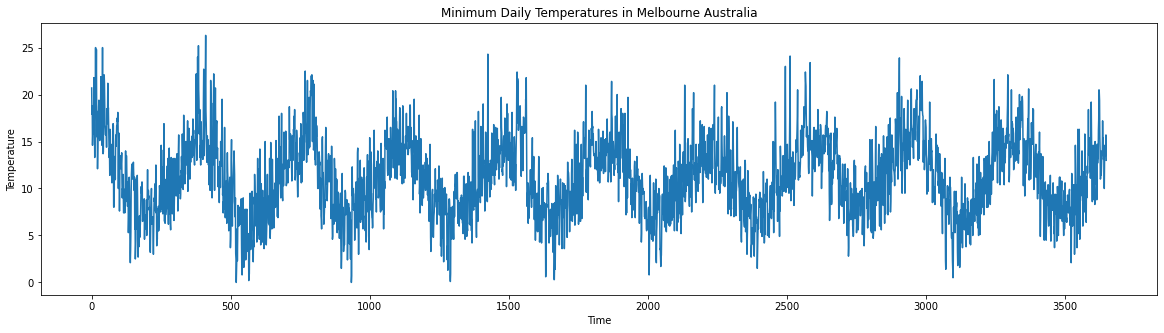

In [3]:
plt.figure(figsize = [20,5])
plt.plot(data.Temp)
plt.title("Minimum Daily Temperatures in Melbourne Australia")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.show()

In [4]:
train_percentage = 0.67
train_size = int(len(data)*train_percentage)

train = data["Temp"][:train_size].values.astype(float)
test = data["Temp"][train_size:].values.astype(float)

sc = MinMaxScaler(feature_range=(-1, 1))
train_norm = sc.fit_transform(train .reshape(-1, 1))

train_norm = torch.FloatTensor(train_norm).view(-1)

In [5]:
np.shape(train_norm)

torch.Size([2445])

In [6]:
def create_input_output(input_data, window, ndays = 1):
    input_output = []
    data_size = len(input_data)
    for i in range(data_size - window - ndays):
        train_seq = input_data[i:i+window]
        train_label = input_data[i+window+ndays:i+window+ndays+1]
        input_output.append((train_seq ,train_label))
    return input_output
ndays = 10
window = 30
train_input_output = create_input_output(train_norm, window, ndays)
train_input_output[:2]

[(tensor([ 0.5741,  0.3612,  0.4297,  0.1103,  0.2015,  0.2015,  0.2015,  0.3232,
           0.6578,  0.5209,  0.2319,  0.0114,  0.2700,  0.6350,  0.9011,  0.5741,
           0.5665,  0.8859,  0.3460,  0.1787,  0.3840, -0.0798,  0.0951,  0.2167,
           0.2548,  0.4221,  0.4753,  0.3080,  0.1787,  0.1483]),
  tensor([0.1407])),
 (tensor([ 0.3612,  0.4297,  0.1103,  0.2015,  0.2015,  0.2015,  0.3232,  0.6578,
           0.5209,  0.2319,  0.0114,  0.2700,  0.6350,  0.9011,  0.5741,  0.5665,
           0.8859,  0.3460,  0.1787,  0.3840, -0.0798,  0.0951,  0.2167,  0.2548,
           0.4221,  0.4753,  0.3080,  0.1787,  0.1483,  0.1711]),
  tensor([0.0418]))]

In [7]:
# Documentation of pytorch Conv1D: https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
class NN_conv(nn.Module):
    def __init__(self):
        super(NN_conv, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv1d(
                in_channels=1,             # Number of channels in the input image
                out_channels=5,            # Number of channels produced by the convolution
                kernel_size=5,             # Size of the convolving kernel 
                stride=1,                  # Stride of the convolution. Default: 1 
                padding=2,                 # Zero-padding added to both sides of the input. Default: 0 
            ),                              
            nn.ReLU(),                      
            nn.MaxPool1d(kernel_size=3),
        )
        self.conv2 = nn.Sequential(         
            nn.Conv1d(
                in_channels=5,             
                out_channels=8,             
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool1d(kernel_size=2),    
            
        )
        self.out = nn.Linear(40, 1)  #output 3 classes: Cargo, Passenger or Fishing


    def forward(self, x):
        #print(x.size())
        x = self.conv1(x)
        #print(x.size())
        x = self.conv2(x)
        #print(x.size())
        x = x.view(-1, 8 * 5)
        #print(x.size())
        output = self.out(x)
        return output


net = NN_conv()

In [8]:
model = NN_conv()
loss_function = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #torch.optim.SGD(model.parameters(), lr=0.001)

In [9]:
epochs = 100

for i in range(epochs):
    for inputs, labels in train_input_output:
        optimizer.zero_grad()
        inputs = inputs.view(1,1,window) # (N,C,L) N is a batch size, C denotes a number of channels, L is a length of signal sequence. https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
        y_pred = model(inputs)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%10 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

/home/zero/Apps/miniconda3/envs/datascience/lib/python3.8/site-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   1 loss: 0.04179106
epoch:  11 loss: 0.04645436
epoch:  21 loss: 0.05112892
epoch:  31 loss: 0.03901842
epoch:  41 loss: 0.07862639
epoch:  51 loss: 0.05256978
epoch:  61 loss: 0.04977160
epoch:  71 loss: 0.05403711
epoch:  81 loss: 0.05928701
epoch:  91 loss: 0.06332270
epoch:  99 loss: 0.0513042919


In [10]:
test_norm = sc.transform(test.reshape(-1, 1))
test_norm = torch.FloatTensor(test_norm).view(-1)
test_input_output = create_input_output(test_norm, window, ndays)
test_input_output[:2]

[(tensor([-0.4829, -0.2928, -0.2548, -0.1863, -0.4068, -0.3004,  0.1407, -0.4068,
          -0.5970, -0.2776, -0.4221,  0.0646,  0.1331,  0.1331,  0.4601,  0.2928,
          -0.0114, -0.1483, -0.2776, -0.2167, -0.2928, -0.1407, -0.5057, -0.0875,
          -0.3688, -0.3384, -0.3384, -0.2243, -0.4753, -0.6274]),
  tensor([-0.2015])),
 (tensor([-0.2928, -0.2548, -0.1863, -0.4068, -0.3004,  0.1407, -0.4068, -0.5970,
          -0.2776, -0.4221,  0.0646,  0.1331,  0.1331,  0.4601,  0.2928, -0.0114,
          -0.1483, -0.2776, -0.2167, -0.2928, -0.1407, -0.5057, -0.0875, -0.3688,
          -0.3384, -0.3384, -0.2243, -0.4753, -0.6274, -0.2395]),
  tensor([-0.1331]))]

In [11]:
y_pred_norm = []
for inputs, labels in test_input_output:
    with torch.no_grad():
        inputs = inputs.view(1,1,window)
        y_pred_norm.append(model(inputs).item())
y_pred_norm[:5]

[-0.1678304672241211,
 -0.18733489513397217,
 -0.15655717253684998,
 -0.23799900710582733,
 -0.25155723094940186]

In [12]:
y_pred = sc.inverse_transform(np.array(y_pred_norm).reshape(-1, 1))
y_pred[:5]

array([[10.94302936],
       [10.68654613],
       [11.09127318],
       [10.02031306],
       [ 9.84202241]])

In [13]:
y_true = test[window+ndays:]

In [14]:
mean_squared_error(y_true, y_pred)

12.942315721880416

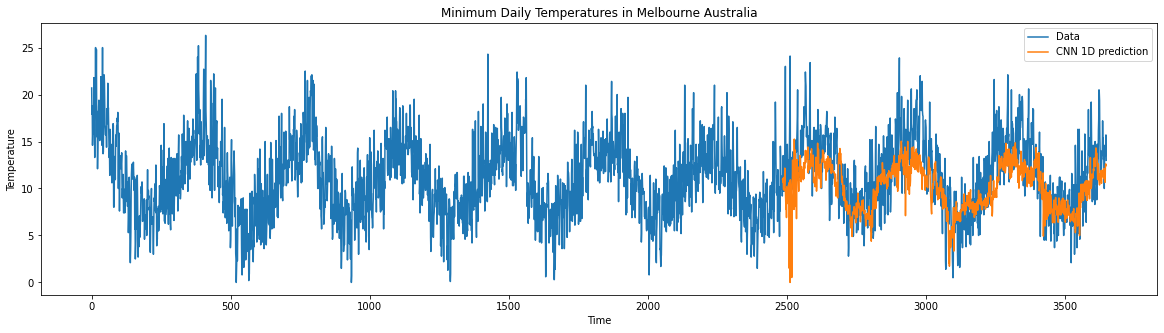

In [15]:
plt.figure(figsize = [20,5])
plt.plot(data.Temp, label="Data")
plt.plot(range(len(train)+window+ndays, len(train) + len(test)), y_pred, label="CNN 1D prediction")
plt.title("Minimum Daily Temperatures in Melbourne Australia")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.legend()
plt.show()